# Importing Libraries

In [9]:
import pandas as pd
import os
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
import logging
import skimage
from scipy import ndimage
from skimage import exposure, color
from skimage.transform import resize

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from keras.utils import to_categorical

In [10]:
#### configuring logging
formatter = logging.Formatter('[%(levelname)s] %(asctime)s: %(message)s')
# Configure stream handler for the cells
chandler = logging.StreamHandler()
chandler.setLevel(logging.DEBUG)
chandler.setFormatter(formatter)

# Add handler
logger = logging.getLogger()
logger.addHandler(chandler)
logger.setLevel(logging.INFO)


# Working Directories

In [13]:
working_dir = "C:/Users/Ruban/Desktop/Guvi IIT Madras Data Science Course/Lincode_Assessment"
img_dir = "C:/Users/Ruban/Desktop/Guvi IIT Madras Data Science Course/Lincode_Assessment/images"
df_meta = pd.read_csv(os.path.join(working_dir,"gicsd_labels.csv"))

# First, second and third class
Before looking into the images themselves, it's interesting to see what's the distribution of the labels in the dataset.

In [14]:
df_meta.columns = df_meta.columns.str.strip()
df_meta.head(10)

,IMAGE_FILENAME,LABEL
0,GICSD_1_0_3.png,FULL_VISIBILITY
1,GICSD_1_0_13.png,FULL_VISIBILITY
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY
3,GICSD_1_1_53.png,FULL_VISIBILITY
4,GICSD_1_2_73.png,FULL_VISIBILITY
5,GICSD_1_3_93.png,FULL_VISIBILITY
6,GICSD_1_3_113.png,FULL_VISIBILITY
7,GICSD_1_4_133.png,FULL_VISIBILITY
8,GICSD_1_5_153.png,FULL_VISIBILITY
9,GICSD_1_5_173.png,FULL_VISIBILITY


In [15]:
df_meta.LABEL.value_counts()

 FULL_VISIBILITY        646
 PARTIAL_VISIBILITY     123
 NO_VISIBILITY           31
Name: LABEL, dtype: int64

# we have a problem of imbalance class
## And what about the metadata?
Metadata are included in the image file name column of the dataset in the form 'GICSD_{CARD_ID}{BACKGROUND_ID}{IMAGE_ID}'. Let's get the metadata in shape

In [16]:
df_meta.LABEL= df_meta.LABEL.str.strip()
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_meta['LABEL'])
logger.debug("encoded classes: %s", list(le.classes_))
df_meta['TARGET'] = le.transform(df_meta['LABEL'])
df_meta['BACKGROUND_ID'] = df_meta['IMAGE_FILENAME'].apply(lambda x: x.split("_")[2]).apply(lambda x: int(x))
df_meta['CARD_ID'] = df_meta['IMAGE_FILENAME'].apply(lambda x: x.split("_")[1]).apply(lambda x: int(x))
df_meta['IMAGE_ID'] = df_meta['IMAGE_FILENAME'].apply(lambda x: x.split("_")[3]).apply(lambda x: x.split(".")[0]).apply(lambda x: int(x))


df_meta.head(10)

,IMAGE_FILENAME,LABEL,TARGET,BACKGROUND_ID,CARD_ID,IMAGE_ID
0,GICSD_1_0_3.png,FULL_VISIBILITY,0,0,1,3
1,GICSD_1_0_13.png,FULL_VISIBILITY,0,0,1,13
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY,2,1,1,33
3,GICSD_1_1_53.png,FULL_VISIBILITY,0,1,1,53
4,GICSD_1_2_73.png,FULL_VISIBILITY,0,2,1,73
5,GICSD_1_3_93.png,FULL_VISIBILITY,0,3,1,93
6,GICSD_1_3_113.png,FULL_VISIBILITY,0,3,1,113
7,GICSD_1_4_133.png,FULL_VISIBILITY,0,4,1,133
8,GICSD_1_5_153.png,FULL_VISIBILITY,0,5,1,153
9,GICSD_1_5_173.png,FULL_VISIBILITY,0,5,1,173


# Plotting Histogram to see the information in data

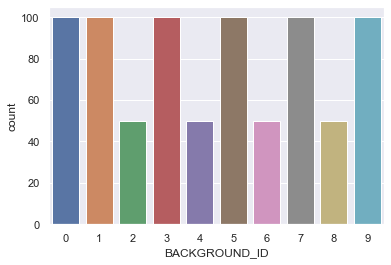

In [17]:
sns.set(style="darkgrid")
ax = sns.countplot(x="BACKGROUND_ID", data=df_meta)

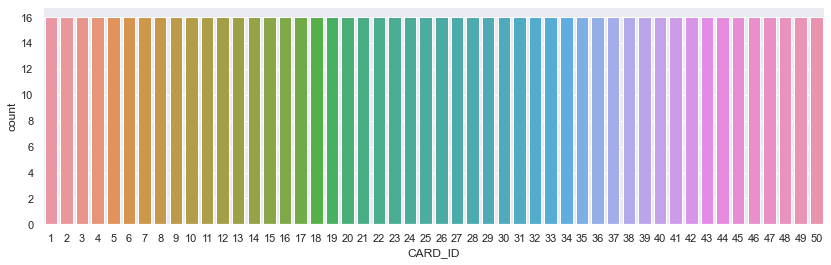

In [18]:
plt.figure(figsize=(14, 4))
ax = sns.countplot(x="CARD_ID", data=df_meta)

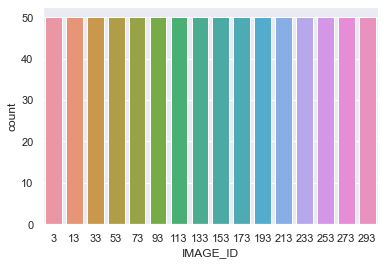

In [19]:
ax = sns.countplot(x="IMAGE_ID", data=df_meta)

[INFO] 2022-12-09 13:45:28,119: NumExpr defaulting to 4 threads.
[INFO] 2022-12-09 13:45:28,119: NumExpr defaulting to 4 threads.


[Text(0, 0, 'full visibility'),
 Text(1, 0, 'no visibility'),
 Text(2, 0, 'partial visibility')]

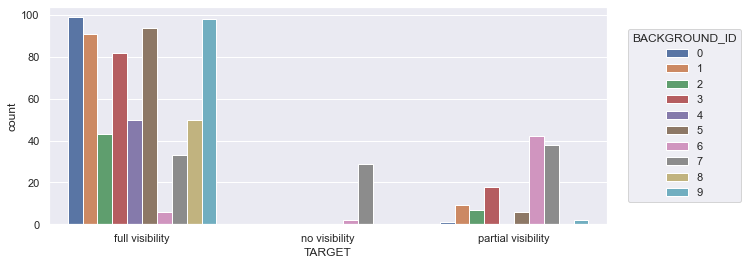

In [20]:
plt.figure(figsize=(10, 4))
ax = sns.countplot(x="TARGET", hue="BACKGROUND_ID", data=df_meta, dodge = True)
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1, title="BACKGROUND_ID")
ticklabels=['full visibility', 'no visibility', 'partial visibility']
ax.xaxis.set_ticklabels(ticklabels)

basically the dataset already provides some sort of 'embedded' augmentation, as there are 16 different shots for each id. For this reason:

when applying augmentation, we will use small parameters for rotation and horizonal, vertical shift, which would ensure we do not change target class;
for this exercise we will discard the info provided by the metadata, assuming the network will learn the feature autonomously.
As a possible improvement to the model, we can include background and card id in a separate input channel.

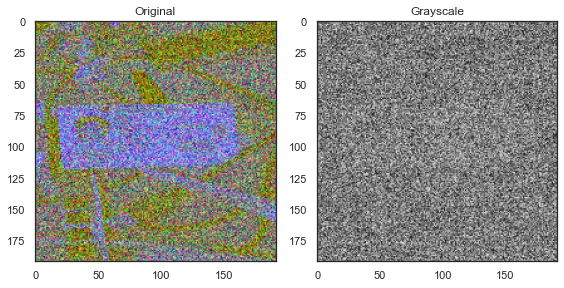

In [21]:
sns.set(style="white")
img = plt.imread(os.path.join(img_dir, df_meta.IMAGE_FILENAME[0]))
grayscale_img1 = color.rgb2gray(img)

def plot_img1_vs_img2(img1, img2, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    ax = axes.ravel()
    ax[0].imshow(img1, cmap=plt.cm.gray)
    ax[0].set_title(title1)
    ax[1].imshow(img2, cmap=plt.cm.gray)
    ax[1].set_title(title2)

    fig.tight_layout()
    plt.show()
    
plot_img1_vs_img2(img, grayscale_img1, "Original", "Grayscale")

This does not look right, the result is simply white noise. Let's look at each channel separately to see if we can spot anything interesting

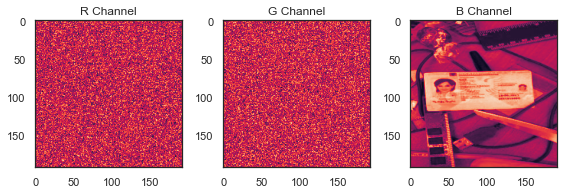

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(img[:,:,0])
ax[0].set_title("R Channel")
ax[1].imshow(img[:,:,1])
ax[1].set_title("G Channel")
ax[2].imshow(img[:,:,2])
ax[2].set_title("B Channel")

fig.tight_layout()
plt.show()


Text(0.5, 1.0, 'B channel in Grayscale')

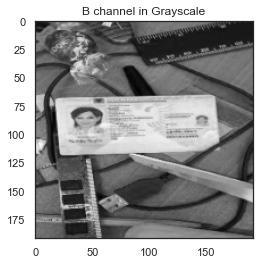

In [23]:
plt.imshow(img[:,:,2], cmap=plt.cm.gray)
plt.title("B channel in Grayscale")

# To B or Not B
## The median (absolute) correlation among the rows in the image matrix is going to be maximum in the channel containing structured information.
If a channel only contains random pixels, the median absolute correlation among the rows in the image matrix should be low. On the other hand, when a channel encodes an actual image, we can expect the presence of some structured information to increase the medain absolute correlation.

We can use this heuristics to see which channels contain the image we have to classify.

In [24]:
from collections import Counter
result = []
for id in range(df_meta.IMAGE_FILENAME.shape[0]):
    img = plt.imread(os.path.join(img_dir, df_meta.IMAGE_FILENAME[id]))
    median_channel_corr = {'R': abs(np.median(np.corrcoef(img[:,:,0]))), 'G': abs(np.median(np.corrcoef(img[:,:,1]))), 'B': abs(np.median(np.corrcoef(img[:,:,2])))}
    #print(median_channel_corr)
    result.append(max(median_channel_corr.keys(), key=(lambda key: median_channel_corr[key])))
    if result[id] != 'B': 
        logger.info("max correlation for img %d is not for channel 'B'", id)

logger.info("count of images detected per channel: %s", Counter(result))


[INFO] 2022-12-09 13:51:11,789: max correlation for img 157 is not for channel 'B'
[INFO] 2022-12-09 13:51:11,789: max correlation for img 157 is not for channel 'B'
[INFO] 2022-12-09 13:51:15,077: max correlation for img 293 is not for channel 'B'
[INFO] 2022-12-09 13:51:15,077: max correlation for img 293 is not for channel 'B'
[INFO] 2022-12-09 13:51:17,170: max correlation for img 369 is not for channel 'B'
[INFO] 2022-12-09 13:51:17,170: max correlation for img 369 is not for channel 'B'
[INFO] 2022-12-09 13:51:18,510: max correlation for img 433 is not for channel 'B'
[INFO] 2022-12-09 13:51:18,510: max correlation for img 433 is not for channel 'B'
[INFO] 2022-12-09 13:51:26,632: count of images detected per channel: Counter({'B': 796, 'R': 3, 'G': 1})
[INFO] 2022-12-09 13:51:26,632: count of images detected per channel: Counter({'B': 796, 'R': 3, 'G': 1})


Only 4 images out 800 have a ax median correlation in a channel different from B. However, a visual inspection of these 4 images shows the relevant information is encoded in the B channel for them as well.

Given that all the relevant information has been found in channel B for all the images in the dataset let's assume the following:
Images in production setup will also contain useful information only in channel B

In [25]:
def to_one_channel(img):
    """ Convert an RGB image to one channel image.
    
    :param img: numpy nd-array - input image.

    :return: numpy nd-array - output image.
    """
    return img[:,:,2]

Before proceeding to model training let's explore some methods that could aid in image recognition

In [26]:

from skimage import exposure, color
from skimage.transform import resize

def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

# Histogram equalization
def HE(img):
    img_eq = exposure.equalize_hist(img)
    return img_eq

# Adaptive histogram equalization
def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

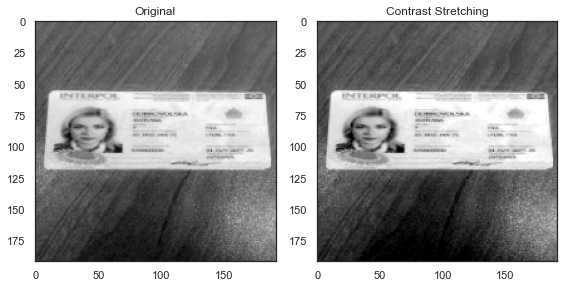

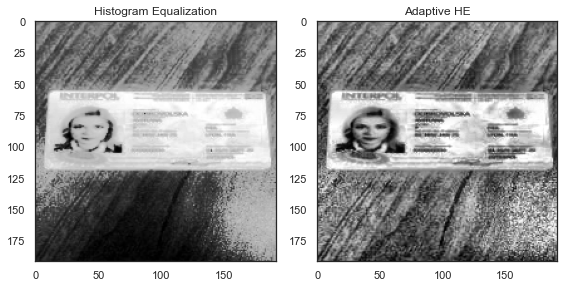

In [27]:
img_cs = contrast_stretching(to_one_channel(img))
img_he = HE(to_one_channel(img))
img_ahe = AHE(to_one_channel(img))
plot_img1_vs_img2(to_one_channel(img), img_cs, "Original", "Contrast Stretching")
plot_img1_vs_img2(img_he, img_ahe, "Histogram Equalization", "Adaptive HE")


Inspecting the transformations above visually suggests that contrast stretching helps to distinguish between the background and the id card better than in the original image, it also doesn't distorting the information on the ID like in case of Histogram Equalization(HE) and Adaptive HE. Therefore it looks like a good approach to apply as part of image preprocessing.

# Model Creation

# Train-test split
Now it's time to split the data into training and testing set. It is important to balance the split with regards to our target column.# 

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_meta.IMAGE_FILENAME, df_meta.TARGET,
                                                    test_size=0.25, random_state=0,
                                                    shuffle=True, stratify=df_meta['TARGET'])



Given that we have strong class imbalance applying oversampling of minority classes (NO_VISIBILITY and PARTIAL_VISIBILITY) to balance the classes in the training set

In [29]:
df_train= df_meta.loc[x_train.index.tolist()]
df_train.shape

(600, 6)

In [30]:

def _oversample_positives(df, target):
    """ Oversample the minority classes to match
    the majority class.
    
    :param df: pandas dataframe - input df.
    :param target: string - classification target column.

    :return: pandas datframe - oversampled version
    """

    class_count = df[target].value_counts()

    print("Before oversampling: %s" % class_count)
    for i in range(1,len(class_count)):
        df_i = df[df[target] == i]
        oversampling_factor_i = class_count[0] / float(class_count[i])
        print(len(df_i))
        print("Oversampling factor for class %i: %s" %(i, str(oversampling_factor_i)))
    
        # Integer part of oversampling
        df = df.append(
            [df_i] * int(math.floor(oversampling_factor_i) - 1),
            ignore_index=False)
        # Float part of oversampling
        df = df.append(
            [df_i.sample(frac=oversampling_factor_i % 1)],
            ignore_index=False)
    
    print("After oversampling: %s" % df[target].value_counts())
    print("Shape after oversampling: %s" % str(df.shape))

    return df

In [31]:
df_train_oversampled = _oversample_positives(df_train, "TARGET")

Before oversampling: 0    485
2     92
1     23
Name: TARGET, dtype: int64
23
Oversampling factor for class 1: 21.08695652173913
92
Oversampling factor for class 2: 5.271739130434782
After oversampling: 0    485
1    485
2    485
Name: TARGET, dtype: int64
Shape after oversampling: (1455, 6)


In [32]:
x_train_oversampled = df_train_oversampled["IMAGE_FILENAME"]
y_train_oversampled = df_train_oversampled["TARGET"]

In [36]:
import keras
from keras.models import Sequential,Model
from keras.layers import Concatenate, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50

def get_model():
   
    base_model = ResNet50(weights='imagenet',include_top=False,input_shape= (192, 192, 3) ) 

    add_model = Sequential()
    add_model.add(Flatten())
    add_model.add(Dense(256, activation='relu', input_dim=6 * 6 * 2048))
    add_model.add(Dropout(0.50))   
    add_model.add(Dense(128, activation='relu')) 
    add_model.add(Dropout(0.50))  
    add_model.add(Dense(64, activation='relu'))    
    add_model.add(Dense(3, activation='softmax'))
    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
    print(base_model.output)
    adam = keras.optimizers.Adam(lr=0.0005)
    model.compile(loss='categorical_crossentropy',metrics=['acc'],
                  optimizer=adam)
    return model
model = get_model()
model.summary()

94765736/94765736 [==============================] - 22s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 2048), dtype=tf.float32, name=None), name='conv5_block3_out/Relu:0', description="created by layer 'conv5_block3_out'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9

C:\Users\Ruban\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 48, 48, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 48, 48, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 48, 48, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 48, 48, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 24, 24, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 24, 24, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 24, 24, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 24, 24, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 12, 12, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 12, 12, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 12, 12, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block4_1_bn (BatchNormal  (None, 12, 12, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 12, 12, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 12, 12, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 12, 12, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 6, 6, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 6, 6, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 6, 6, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 6, 6, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
Total params: 42,503,683
Trainable params: 42,450,563
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [37]:
X_train_images = []
for file in x_train_oversampled:
    train_img = to_one_channel(plt.imread(os.path.join(img_dir, file)))
    train_img = np.stack((train_img,)*3, axis=-1)
    train_img = contrast_stretching(train_img)
    X_train_images.append(train_img)
X_train_images = np.array(X_train_images)

In [38]:
X_train_images.shape

(1455, 192, 192, 3)

In [39]:
# converting to one-hot-encoding required by categorical_crossentropy loss
y_train_binary = to_categorical(y_train_oversampled)

X_test_images = []
for file in x_test:
    test_img = to_one_channel(plt.imread(os.path.join(img_dir, file)))
    test_img = np.stack((test_img,)*3, axis=-1)
    test_img = contrast_stretching(test_img)
    X_test_images.append(test_img)
X_test_images = np.array(X_test_images)

In [40]:
datagen = ImageDataGenerator(
    rotation_range=4,
    width_shift_range=[-2, 2],
    height_shift_range=[-5, 5])


In [41]:
model.fit_generator(datagen.flow(X_train_images, y_train_binary, batch_size=32), verbose = 1, epochs=35, shuffle=True)

<ipython-input-41-6593864b8496>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(X_train_images, y_train_binary, batch_size=32), verbose = 1, epochs=35, shuffle=True)


Epoch 1/35
46/46 [==============================] - 801s 17s/step - loss: 2.2400 - acc: 0.5553
Epoch 2/35
46/46 [==============================] - 696s 15s/step - loss: 1.1385 - acc: 0.7471
Epoch 3/35
46/46 [==============================] - 650s 14s/step - loss: 0.7629 - acc: 0.8460
Epoch 4/35
46/46 [==============================] - 727s 16s/step - loss: 0.3408 - acc: 0.9148
Epoch 5/35
46/46 [==============================] - 779s 17s/step - loss: 0.2621 - acc: 0.9450
Epoch 6/35
46/46 [==============================] - 716s 16s/step - loss: 0.2637 - acc: 0.9340
Epoch 7/35
46/46 [==============================] - 658s 14s/step - loss: 0.2593 - acc: 0.9368
Epoch 8/35
46/46 [==============================] - 656s 14s/step - loss: 0.2465 - acc: 0.9498
Epoch 9/35
46/46 [==============================] - 650s 14s/step - loss: 0.3781 - acc: 0.9402
Epoch 10/35
46/46 [==============================] - 656s 14s/step - loss: 0.1908 - acc: 0.9643
Epoch 11/35
46/46 [==============================

# Predictions

In [42]:
predictions = model.predict(X_test_images)
predictions[0:5]

7/7 [==============================] - 21s 3s/step


array([[9.5213658e-01, 9.2244381e-03, 3.8638938e-02],
       [9.9947852e-01, 2.8713459e-06, 5.1862246e-04],
       [6.6718352e-01, 4.4575017e-02, 2.8824142e-01],
       [9.9999833e-01, 2.7950675e-09, 1.7100864e-06],
       [9.9984682e-01, 4.3997366e-06, 1.4878958e-04]], dtype=float32)

In [43]:
#converting predictions to a single number
predictions_num = np.argmax(predictions, axis=1)
predictions_num


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0], dtype=int64)

In [44]:
class_map = {0:"FULL_VISIBILITY", 1:"NO_VISIBILITY", 2:"PARTIAL_VISIBILITY"}
class_map[predictions_num[0]]

'FULL_VISIBILITY'

# Evaluation

In [45]:
# Check AUC of the model
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_num, pos_label=2)
auc = metrics.auc(fpr, tpr)
f1_score = metrics.f1_score(y_true = y_test, y_pred = predictions_num, average=None)
f1_score_weighted = metrics.f1_score(y_true = y_test, y_pred = predictions_num, average='weighted')
print("auc = %f" % auc)
print("f1_score_weighted = %s" % f1_score_weighted)
print("f1_score = %s" % f1_score)


auc = 0.564230
f1_score_weighted = 0.7895288981288983
f1_score = [0.90857143 0.61538462 0.21621622]


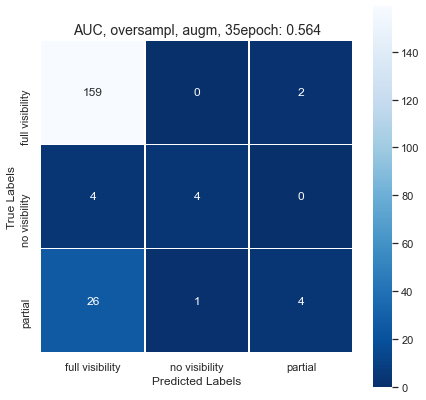

In [46]:
cm = metrics.confusion_matrix(y_test, predictions_num)

plt.figure(figsize=(7,7))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=12);
ax.set_ylabel('True Labels', size=12); 
ax.set_title('AUC, oversampl, augm, 35epoch: {:.3f}'.format(auc), size=14); 
ticklabels=['full visibility', 'no visibility', 'partial']
ax.xaxis.set_ticklabels(ticklabels); 
ax.yaxis.set_ticklabels(ticklabels);

# Production Model

In [47]:
df_prod_oversampled = _oversample_positives(df_meta, "TARGET")
x_prod_oversampled = df_prod_oversampled["IMAGE_FILENAME"]
y_prod_oversampled = df_prod_oversampled["TARGET"]


Before oversampling: 0    646
2    123
1     31
Name: TARGET, dtype: int64
31
Oversampling factor for class 1: 20.838709677419356
123
Oversampling factor for class 2: 5.252032520325203
After oversampling: 0    646
1    646
2    646
Name: TARGET, dtype: int64
Shape after oversampling: (1938, 6)


In [48]:
X_prod_images = []
for file in x_prod_oversampled:
    prod_img = to_one_channel(plt.imread(os.path.join(img_dir, file)))
    prod_img = np.stack((prod_img,)*3, axis=-1)
    prod_img = contrast_stretching(prod_img)
    X_prod_images.append(prod_img)
X_prod_images = np.array(X_prod_images)
y_prod_binary = to_categorical(y_prod_oversampled)

In [49]:
model.fit_generator(datagen.flow(X_prod_images, y_prod_binary, batch_size=32), verbose = 1, epochs=35, shuffle=True)

<ipython-input-49-282e2738fd0e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(X_prod_images, y_prod_binary, batch_size=32), verbose = 1, epochs=35, shuffle=True)


Epoch 1/35
61/61 [==============================] - 966s 16s/step - loss: 0.2091 - acc: 0.9463
Epoch 2/35
61/61 [==============================] - 920s 15s/step - loss: 0.1653 - acc: 0.9603
Epoch 3/35
61/61 [==============================] - 1151s 19s/step - loss: 0.1052 - acc: 0.9716
Epoch 4/35
61/61 [==============================] - 967s 16s/step - loss: 0.0646 - acc: 0.9799
Epoch 5/35
61/61 [==============================] - 1050s 17s/step - loss: 0.0404 - acc: 0.9866
Epoch 6/35
61/61 [==============================] - 906s 15s/step - loss: 0.0500 - acc: 0.9876
Epoch 7/35
61/61 [==============================] - 874s 14s/step - loss: 0.0894 - acc: 0.9778
Epoch 8/35
61/61 [==============================] - 875s 14s/step - loss: 0.0808 - acc: 0.9794
Epoch 9/35
61/61 [==============================] - 895s 15s/step - loss: 0.0606 - acc: 0.9850
Epoch 10/35
61/61 [==============================] - 870s 14s/step - loss: 0.0505 - acc: 0.9840
Epoch 11/35
61/61 [============================

In [51]:
# saving the model
model.save('prod_oversampling_model.h5') 